In [1]:
%config Completer.use_jedi = False

import os
os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"   # see issue #152
os.environ["CUDA_VISIBLE_DEVICES"] = ""

# example of training an conditional gan on the fashion mnist dataset
from numpy import expand_dims
from numpy import zeros
from numpy import ones
from numpy.random import randn
from numpy.random import randint
from keras.optimizers import Adam
from keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau, LearningRateScheduler
from keras.utils import plot_model
from keras.models import Model
from keras.layers import Input, Reshape, multiply, Embedding, merge, Concatenate, Conv1D, BatchNormalization
from keras.layers import Dense, Flatten
from keras.layers.advanced_activations import LeakyReLU
import numpy as np

In [2]:
# X = np.load('Data/X.npy')
# y = np.load('Data/y.npy')

# # print (X.shape, y.shape)

# X_N = X[y==0]
# X_S = X[y==1]
# X_V = X[y==2]

# y_N = y[y==0]
# y_S = y[y==1]
# y_V = y[y==2]

# # print (X_N.shape, y_N.shape)
# # print (X_S.shape, y_S.shape)
# # print (X_V.shape, y_V.shape)

# X_N=X_N.reshape(X_N.shape[0],X_N.shape[1],1)
# X_S=X_S.reshape(X_S.shape[0],X_S.shape[1],1)
# X_V=X_V.reshape(X_V.shape[0],X_V.shape[1],1)

# print (X_N.shape, y_N.shape)
# print (X_S.shape, y_S.shape)
# print (X_V.shape, y_V.shape)

In [3]:
def discriminator(data_dim, input_classes=3):
    
    in_label = Input(shape=(1,))
    x = Embedding(input_classes, 30)(in_label)
    x = Dense(data_dim)(x)
    x = Reshape((data_dim,1))(x)
    
    D_in = Input(shape=[data_dim,1])
    x = Concatenate()([D_in, x])
    
    x = Conv1D(filters=32, kernel_size=4, strides=2, padding='same', kernel_initializer='he_normal')(x)
    x = BatchNormalization()(x)
    x = LeakyReLU(alpha=0.2)(x)
    
    x = Conv1D(filters=32*2, kernel_size=4, strides=2, padding='same', kernel_initializer='he_normal')(x)
    x = BatchNormalization()(x)
    x = LeakyReLU(alpha=0.2)(x)
    
    x = Conv1D(filters=32*4, kernel_size=4, strides=2, padding='same', kernel_initializer='he_normal')(x)
    x = BatchNormalization()(x)
    x = LeakyReLU(alpha=0.2)(x)
    
    x = Conv1D(filters=32*8, kernel_size=4, strides=2, padding='same', kernel_initializer='he_normal')(x)
    x = BatchNormalization()(x)
    x = LeakyReLU(alpha=0.2)(x)
    
    x = Conv1D(filters=32*16, kernel_size=4, strides=2, padding='same', kernel_initializer='he_normal')(x)
    x = BatchNormalization()(x)
    x = LeakyReLU(alpha=0.2)(x)
    
    x = Flatten()(x)
    out = Dense(1, activation='sigmoid')(x)
    
    model = Model(inputs=[D_in, in_label], outputs=out)
    opt = Adam(lr=0.0002, beta_1=0.5)
    loss = 'binary_crossentropy'
    model.compile(loss=loss, optimizer=opt, metrics=['accuracy'])
    return model

d_model = discriminator(data_dim=186, input_classes=3)
# plot_model(d_model, to_file='disc.png', show_shapes=True)

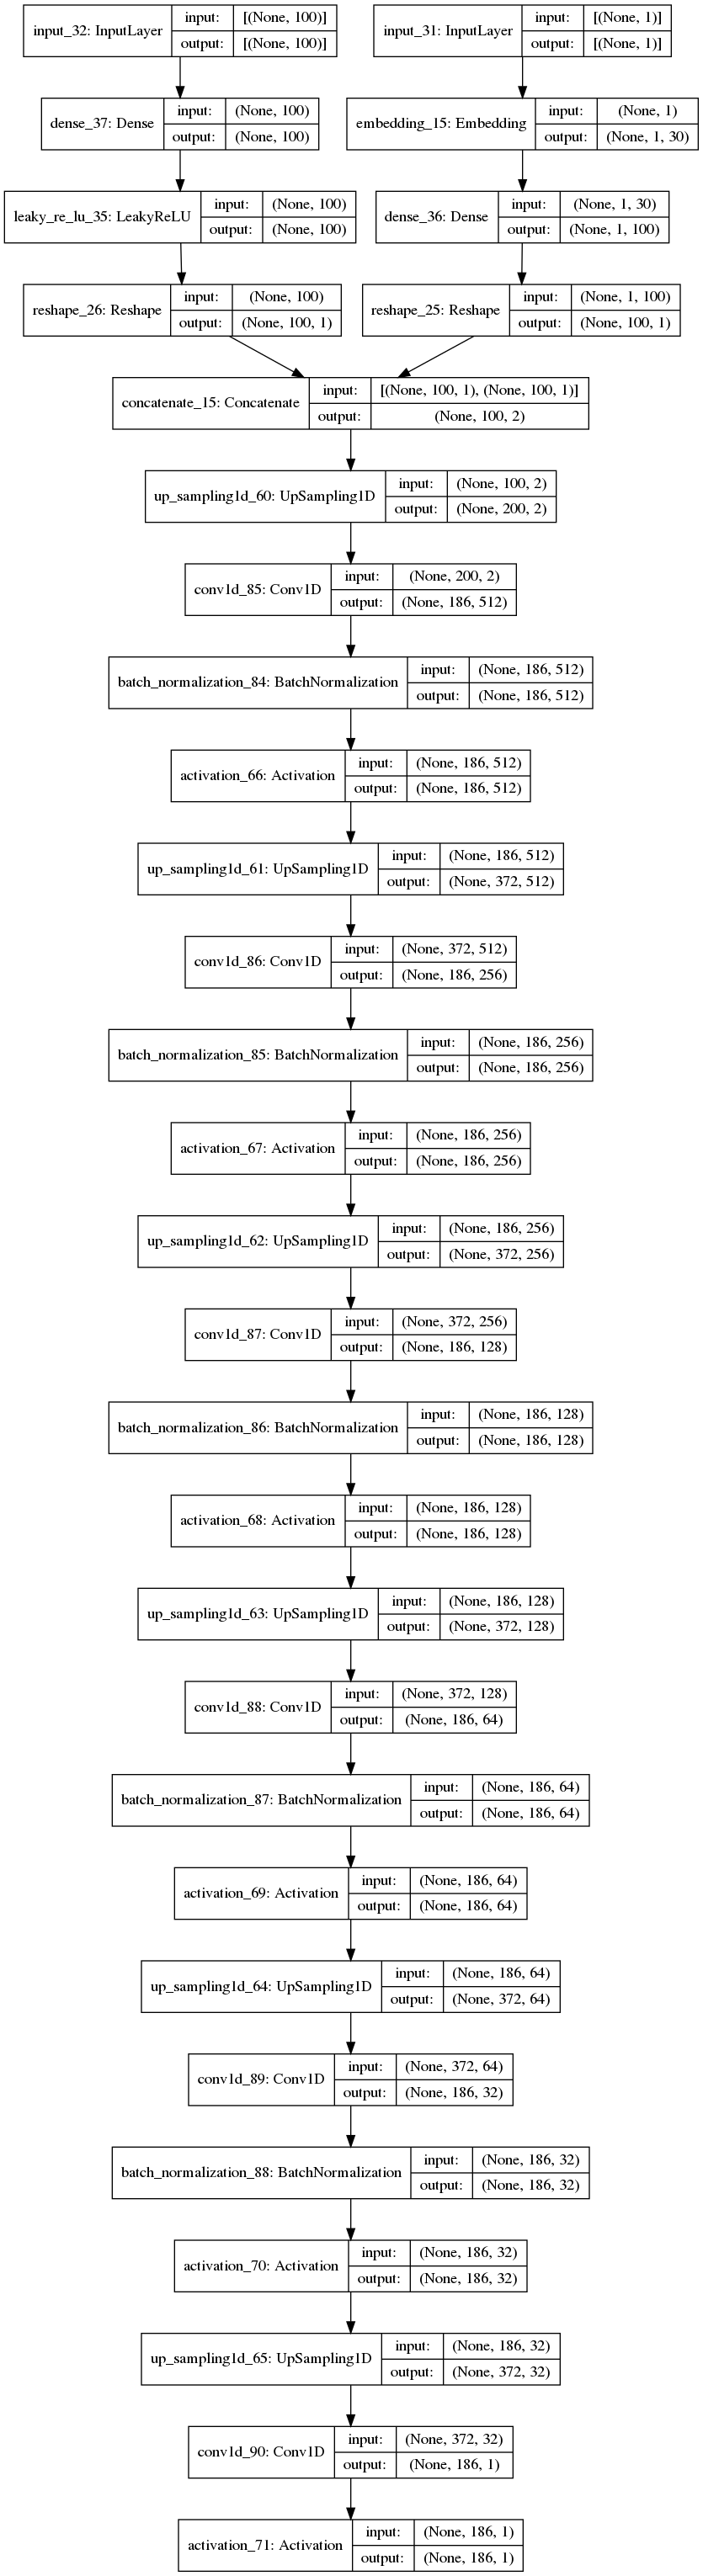

In [27]:
from keras.layers import UpSampling1D
from keras.layers.core import Activation

def generator(noise_dim=100, input_classes=3, out_dim=186):
    
    in_label = Input(shape=(1,))
    x = Embedding(input_classes, 30)(in_label)
    x = Dense(noise_dim)(x)
    x = Reshape((noise_dim,1))(x)
    
    G_in = Input(shape=[noise_dim,])
    gen = Dense(noise_dim)(G_in)
    gen = LeakyReLU(alpha=0.2)(gen)
    gen = Reshape((noise_dim,1))(gen)

    x = Concatenate()([gen, x])
    
    x = UpSampling1D()(x)
    x = Conv1D(filters=32*16, kernel_size=15, strides=1, padding='valid', kernel_initializer='he_normal')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    x = UpSampling1D()(x)
    x = Conv1D(filters=32*8, kernel_size=4, strides=2, padding='same', kernel_initializer='he_normal')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    
    x = UpSampling1D()(x)
    x = Conv1D(filters=32*4, kernel_size=4, strides=2, padding='same', kernel_initializer='he_normal')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    
    x = UpSampling1D()(x)
    x = Conv1D(filters=32*2, kernel_size=4, strides=2, padding='same', kernel_initializer='he_normal')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    
    x = UpSampling1D()(x)
    x = Conv1D(filters=32, kernel_size=4, strides=2, padding='same', kernel_initializer='he_normal')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    
    x = UpSampling1D()(x)
    x = Conv1D(filters=1, kernel_size=4, strides=2, padding='same', kernel_initializer='he_normal')(x)
    out = Activation('tanh')(x)
    model = Model(inputs=[G_in, in_label], outputs=out)

#     x = UpSampling1D()(x)
#     x = Conv1D(filters=1, kernel_size=4, strides=2, padding='same', kernel_initializer='he_normal')(x)
#     x = BatchNormalization()(x)
#     x = Activation('relu')(x)
    
#     x = Flatten()(x)
#     x = Dense(out_dim)(x)
#     out = Activation('tanh')(x)
#     model = Model(inputs=[G_in, in_label], outputs=out)
    return model

g_model = generator(noise_dim=100, input_classes=3, out_dim=186)
plot_model(g_model, to_file='gen.png', show_shapes=True)

In [5]:
def create_gan(d_model, g_model):
    
    # make weights in the discriminator not trainable
    d_model.trainable = False
    # get noise and label inputs from generator model
    gen_noise, gen_label = g_model.input
    # get image output from the generator model
    gen_output = g_model.output
    # connect image output and label input from generator as inputs to discriminator
    gan_output = d_model([gen_output, gen_label])
    # define gan model as taking noise and label and outputting a classification
    model = Model([gen_noise, gen_label], gan_output)
    # compile model
    opt = Adam(lr=0.0002, beta_1=0.5)
    loss = 'binary_crossentropy'
    model.compile(loss=loss, optimizer=opt)
    return model

gan_model = create_gan(d_model, g_model)
# plot_model(gan_model, to_file='gan.png', show_shapes=True)

In [22]:
def load_real_samples():
    X = np.load('Data/X.npy')
    y = np.load('Data/y.npy')

    # print (X.shape, y.shape)

    X_N = X[y==0]
    X_S = X[y==1]
    X_V = X[y==2]

    y_N = y[y==0]
    y_S = y[y==1]
    y_V = y[y==2]

    # print (X_N.shape, y_N.shape)
    # print (X_S.shape, y_S.shape)
    # print (X_V.shape, y_V.shape)

    X_N=X_N.reshape(X_N.shape[0],X_N.shape[1],1)
    X_S=X_S.reshape(X_S.shape[0],X_S.shape[1],1)
    X_V=X_V.reshape(X_V.shape[0],X_V.shape[1],1)

    print (X_N.shape, y_N.shape)
    print (X_S.shape, y_S.shape)
    print (X_V.shape, y_V.shape)
    return X_N, y_N, X_S, y_S, X_V, y_V

In [54]:
def generate_real_samples(X_N, y_N, X_S, y_S, X_V, y_V, n_samples):
    
    # choose random instances
    i_N = randint(0, y_N.shape[0], int(n_samples/3))
    i_S = randint(0, y_S.shape[0], int(n_samples/3))
    i_V = randint(0, y_V.shape[0], int(n_samples/3))
    
    # select ECG and labels
    X = np.vstack((X_N[i_N], X_S[i_S], X_V[i_V]))
    labels = np.hstack((y_N[i_N], y_S[i_S], y_V[i_V]))
    
    # generate class labels
    y = ones((n_samples, 1))
    return [X, labels], y

In [62]:
# generate points in latent space as input for the generator
def generate_latent_points(latent_dim, n_samples, n_classes=3):
    # generate points in the latent space
    x_input = randn(latent_dim * n_samples)
    # reshape into a batch of inputs for the network
    z_input = x_input.reshape(n_samples, latent_dim)
    # generate labels
    labels = randint(0, n_classes, n_samples)
    return [z_input, labels]

In [63]:
# use the generator to generate n fake examples, with class labels
def generate_fake_samples(generator, latent_dim, n_samples):
    # generate points in latent space
    z_input, labels_input = generate_latent_points(latent_dim, n_samples)
    # predict outputs
    images = generator.predict([z_input, labels_input])
    # create class labels
    y = zeros((n_samples, 1))
    return [images, labels_input], y

In [30]:
# size of the latent space
latent_dim = 100
# size of the data
data = 186
# classes
classes = 3

n_epochs=100

# multiples of three (three classes)
n_batch=60

# create the discriminator
d_model = discriminator(data_dim=data, input_classes=classes)
# create the generator
g_model = generator(noise_dim=latent_dim, input_classes=classes, out_dim=data)
# create the gan
gan_model = create_gan(d_model, g_model)

# load image data
X_N, y_N, X_S, y_S, X_V, y_V = load_real_samples()
# # train model
# train(g_model, d_model, gan_model, dataset, latent_dim)

bat_per_epo = int(y_S.shape[0] / n_batch)
half_batch = int(n_batch / 2)

(80000, 186, 1) (80000,)
(24227, 186, 1) (24227,)
(71985, 186, 1) (71985,)


In [64]:
# manually enumerate epochs
for i in range(n_epochs):
    # enumerate batches over the training set
    for j in range(bat_per_epo):
        # get randomly selected 'real' samples
        [X_real, labels_real], y_real = generate_real_samples(X_N, y_N, X_S, y_S, X_V, y_V, half_batch)
        # update discriminator model weights
        d_loss1, _ = d_model.train_on_batch([X_real, labels_real], y_real)
        # generate 'fake' examples
        [X_fake, labels], y_fake = generate_fake_samples(g_model, latent_dim, half_batch)
        # update discriminator model weights
        d_loss2, _ = d_model.train_on_batch([X_fake, labels], y_fake)
        # prepare points in latent space as input for the generator
        [z_input, labels_input] = generate_latent_points(latent_dim, n_batch)
        # create inverted labels for the fake samples
        y_gan = ones((n_batch, 1))
        # update the generator via the discriminator's error
        g_loss = gan_model.train_on_batch([z_input, labels_input], y_gan)
        # summarize loss on this batch
        print('>%d, %d/%d, d1=%.3f, d2=%.3f g=%.3f' %
            (i+1, j+1, bat_per_epo, d_loss1, d_loss2, g_loss))
# save the generator model
g_model.save('cgan_generator.h5')

>1, 1/403, d1=0.275, d2=1.406 g=0.638
>1, 2/403, d1=0.077, d2=1.342 g=0.802
>1, 3/403, d1=0.058, d2=0.721 g=1.073
>1, 4/403, d1=0.063, d2=0.571 g=1.234
>1, 5/403, d1=0.078, d2=0.552 g=1.313
>1, 6/403, d1=0.077, d2=0.346 g=1.412
>1, 7/403, d1=0.057, d2=0.239 g=1.469
>1, 8/403, d1=0.084, d2=0.292 g=1.455
>1, 9/403, d1=0.050, d2=0.190 g=1.549
>1, 10/403, d1=0.067, d2=0.287 g=1.510
>1, 11/403, d1=0.057, d2=0.195 g=1.481
>1, 12/403, d1=0.131, d2=0.145 g=1.212
>1, 13/403, d1=0.051, d2=0.110 g=1.259
>1, 14/403, d1=0.058, d2=0.141 g=1.182
>1, 15/403, d1=0.044, d2=0.085 g=1.392


KeyboardInterrupt: 

In [ ]:
callback = [EarlyStopping(monitor='val_AUC', mode='max', verbose=1, patience=Pat),
         ModelCheckpoint(filepath=str(twelve_lead_model_filename)+'_check_model.h5', 
                         monitor='val_AUC', verbose=1, save_best_only=True, mode='max'),
         ReduceLROnPlateau(monitor='val_AUC', factor=0.5, patience=Pat//2, verbose=1, 
                           mode='max', min_delta=0.0001, cooldown=0, min_lr=0)]

# model = parallel_NN(WINDOW_SIZE,INPUT_FEAT,OUTPUT_CLASS):
model = parallel_NN(Window, len(leads), snomed_classes.shape[0])

model.compile(loss=tf.keras.losses.BinaryCrossentropy(), 
              optimizer=tf.keras.optimizers.Adam(learning_rate=0.001), 
              metrics=[tf.keras.metrics.BinaryAccuracy(name='accuracy', dtype=None, threshold=0.5),
                       tf.keras.metrics.Recall(name='Recall'),
                       tf.keras.metrics.Precision(name='Precision'),
                       tf.keras.metrics.AUC(num_thresholds=200,summation_method="interpolation",
                                            name="AUC",dtype=None,curve="ROC",thresholds=None,
                                            multi_label=True,label_weights=None)])
history = model.fit(train_generator, steps_per_epoch=train_samples, epochs=EP, verbose=1,
                validation_data=val_generator, validation_steps=val_samples, callbacks=callback)


history_name = output_directory + '/' + twelve_lead_filename
print (twelve_lead_model_filename, history_name)

save_model(twelve_lead_model_filename, model)
write_history(history_name, history.history)

In [ ]:


# select real samples
def generate_real_samples(dataset, n_samples):
    # split into images and labels
    images, labels = dataset
    # choose random instances
    ix = randint(0, images.shape[0], n_samples)
    # select images and labels
    X, labels = images[ix], labels[ix]
    # generate class labels
    y = ones((n_samples, 1))
    return [X, labels], y

(176212, 186) (176212,)
(80000, 186) (80000,)
(24227, 186) (24227,)
(71985, 186) (71985,)
(80000, 186, 1) (80000,)
(24227, 186, 1) (24227,)
(71985, 186, 1) (71985,)


In [ ]:
# example of training an conditional gan on the fashion mnist dataset
from numpy import expand_dims
from numpy import zeros
from numpy import ones
from numpy.random import randn
from numpy.random import randint
from keras.optimizers import Adam
from keras.models import Model
from keras.layers import Input
from keras.layers import Dense
from keras.layers import Reshape
from keras.layers import Flatten
from keras.layers import Conv2D
from keras.layers import Conv2DTranspose
from keras.layers import LeakyReLU
from keras.layers import Dropout
from keras.layers import Embedding
from keras.layers import Concatenate

# define the standalone discriminator model
def define_discriminator(in_shape=(28,28,1), n_classes=10):
	# label input
	in_label = Input(shape=(1,))
	# embedding for categorical input
	li = Embedding(n_classes, 50)(in_label)
	# scale up to image dimensions with linear activation
	n_nodes = in_shape[0] * in_shape[1]
	li = Dense(n_nodes)(li)
	# reshape to additional channel
	li = Reshape((in_shape[0], in_shape[1], 1))(li)
	# image input
	in_image = Input(shape=in_shape)
	# concat label as a channel
	merge = Concatenate()([in_image, li])
	# downsample
	fe = Conv2D(128, (3,3), strides=(2,2), padding='same')(merge)
	fe = LeakyReLU(alpha=0.2)(fe)
	# downsample
	fe = Conv2D(128, (3,3), strides=(2,2), padding='same')(fe)
	fe = LeakyReLU(alpha=0.2)(fe)
	# flatten feature maps
	fe = Flatten()(fe)
	# dropout
	fe = Dropout(0.4)(fe)
	# output
	out_layer = Dense(1, activation='sigmoid')(fe)
	# define model
	model = Model([in_image, in_label], out_layer)
	# compile model
	opt = Adam(lr=0.0002, beta_1=0.5)
	model.compile(loss='binary_crossentropy', optimizer=opt, metrics=['accuracy'])
	return model

# define the standalone generator model
def define_generator(latent_dim, n_classes=10):
	# label input
	in_label = Input(shape=(1,))
	# embedding for categorical input
	li = Embedding(n_classes, 50)(in_label)
	# linear multiplication
	n_nodes = 7 * 7
	li = Dense(n_nodes)(li)
	# reshape to additional channel
	li = Reshape((7, 7, 1))(li)
	# image generator input
	in_lat = Input(shape=(latent_dim,))
	# foundation for 7x7 image
	n_nodes = 128 * 7 * 7
	gen = Dense(n_nodes)(in_lat)
	gen = LeakyReLU(alpha=0.2)(gen)
	gen = Reshape((7, 7, 128))(gen)
	# merge image gen and label input
	merge = Concatenate()([gen, li])
	# upsample to 14x14
	gen = Conv2DTranspose(128, (4,4), strides=(2,2), padding='same')(merge)
	gen = LeakyReLU(alpha=0.2)(gen)
	# upsample to 28x28
	gen = Conv2DTranspose(128, (4,4), strides=(2,2), padding='same')(gen)
	gen = LeakyReLU(alpha=0.2)(gen)
	# output
	out_layer = Conv2D(1, (7,7), activation='tanh', padding='same')(gen)
	# define model
	model = Model([in_lat, in_label], out_layer)
	return model

# define the combined generator and discriminator model, for updating the generator
def define_gan(g_model, d_model):
	# make weights in the discriminator not trainable
	d_model.trainable = False
	# get noise and label inputs from generator model
	gen_noise, gen_label = g_model.input
	# get image output from the generator model
	gen_output = g_model.output
	# connect image output and label input from generator as inputs to discriminator
	gan_output = d_model([gen_output, gen_label])
	# define gan model as taking noise and label and outputting a classification
	model = Model([gen_noise, gen_label], gan_output)
	# compile model
	opt = Adam(lr=0.0002, beta_1=0.5)
	model.compile(loss='binary_crossentropy', optimizer=opt)
	return model

# load fashion mnist images
def load_real_samples():
	# load dataset
	(trainX, trainy), (_, _) = load_data()
	# expand to 3d, e.g. add channels
	X = expand_dims(trainX, axis=-1)
	# convert from ints to floats
	X = X.astype('float32')
	# scale from [0,255] to [-1,1]
	X = (X - 127.5) / 127.5
	return [X, trainy]

# # select real samples
def generate_real_samples(dataset, n_samples):
	# split into images and labels
	images, labels = dataset
	# choose random instances
	ix = randint(0, images.shape[0], n_samples)
	# select images and labels
	X, labels = images[ix], labels[ix]
	# generate class labels
	y = ones((n_samples, 1))
	return [X, labels], y

# generate points in latent space as input for the generator
def generate_latent_points(latent_dim, n_samples, n_classes=10):
	# generate points in the latent space
	x_input = randn(latent_dim * n_samples)
	# reshape into a batch of inputs for the network
	z_input = x_input.reshape(n_samples, latent_dim)
	# generate labels
	labels = randint(0, n_classes, n_samples)
	return [z_input, labels]

# use the generator to generate n fake examples, with class labels
def generate_fake_samples(generator, latent_dim, n_samples):
	# generate points in latent space
	z_input, labels_input = generate_latent_points(latent_dim, n_samples)
	# predict outputs
	images = generator.predict([z_input, labels_input])
	# create class labels
	y = zeros((n_samples, 1))
	return [images, labels_input], y

# example of loading the generator model and generating images
from numpy import asarray
from numpy.random import randn
from numpy.random import randint
from keras.models import load_model
from matplotlib import pyplot

# generate points in latent space as input for the generator
def generate_latent_points(latent_dim, n_samples, n_classes=10):
	# generate points in the latent space
	x_input = randn(latent_dim * n_samples)
	# reshape into a batch of inputs for the network
	z_input = x_input.reshape(n_samples, latent_dim)
	# generate labels
	labels = randint(0, n_classes, n_samples)
	return [z_input, labels]

# create and save a plot of generated images
def save_plot(examples, n):
    # plot images
    pyplot.figure(figsize=(10,10))
    for i in range(n * n):
        # define subplot
        pyplot.subplot(n, n, 1 + i)
        # turn off axis
        pyplot.axis('off')
        # plot raw pixel data
        pyplot.imshow(examples[i, :, :, 0], cmap='gray_r')
    pyplot.show()
    pyplot.close()

# train the generator and discriminator
def train(g_model, d_model, gan_model, dataset, latent_dim, n_epochs=1000, n_batch=128):
    bat_per_epo = int(dataset[0].shape[0] / n_batch)
    half_batch = int(n_batch / 2)
    # manually enumerate epochs
    for i in range(n_epochs):
        # enumerate batches over the training set
        for j in range(bat_per_epo):
            # get randomly selected 'real' samples
            [X_real, labels_real], y_real = generate_real_samples(dataset, half_batch)
            # update discriminator model weights
            d_loss1, _ = d_model.train_on_batch([X_real, labels_real], y_real)
            # generate 'fake' examples
            [X_fake, labels], y_fake = generate_fake_samples(g_model, latent_dim, half_batch)
            # update discriminator model weights
            d_loss2, _ = d_model.train_on_batch([X_fake, labels], y_fake)
            # prepare points in latent space as input for the generator
            [z_input, labels_input] = generate_latent_points(latent_dim, n_batch)
            # create inverted labels for the fake samples
            y_gan = ones((n_batch, 1))
            # update the generator via the discriminator's error
            g_loss = gan_model.train_on_batch([z_input, labels_input], y_gan)
            # summarize loss on this batch
            if j%100 == 0:
                print('>%d, %d/%d, d1=%.3f, d2=%.3f g=%.3f' %(i+1, j+1, bat_per_epo, d_loss1, d_loss2, g_loss))
        if i%2==0:
            # load model
            model = g_model
            # generate images
            latent_points, labels = generate_latent_points(100, 100)
            # specify labels
            labels = asarray([x for _ in range(10) for x in range(10)])
            # generate images
            X  = model.predict([latent_points, labels])
            # scale from [-1,1] to [0,1]
            X = (X + 1) / 2.0
            # plot the result
            save_plot(X, 10)
    # save the generator model
    g_model.save('cgan_generator.h5')

# size of the latent space
latent_dim = 100
# create the discriminator
d_model = define_discriminator()
# create the generator
g_model = define_generator(latent_dim)
# create the gan
gan_model = define_gan(g_model, d_model)
# load image data
dataset = load_real_samples()
# train model
train(g_model, d_model, gan_model, dataset, latent_dim, n_epochs=1000, n_batch=512)

>1, 1/117, d1=0.677, d2=0.695 g=0.692
>1, 101/117, d1=0.299, d2=0.989 g=0.653


In [ ]:
# # load model
# model = load_model('cgan_generator.h5')
# # generate images
# latent_points, labels = generate_latent_points(100, 100)
# # specify labels
# labels = asarray([x for _ in range(10) for x in range(10)])
# # generate images
# X  = model.predict([latent_points, labels])
# # scale from [-1,1] to [0,1]
# X = (X + 1) / 2.0
# # plot the result
# save_plot(X, 10)